In [1]:
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
import statsmodels.api as sm

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### Importing Data

In [3]:
names=["Date","Value"]
series = read_csv('INR-vs-USD.csv',index_col=0,names=names,header=0)
series.index = pd.to_datetime(series.index)
resampled_series = series['Value'].resample('D').ffill()

<AxesSubplot:xlabel='Date'>

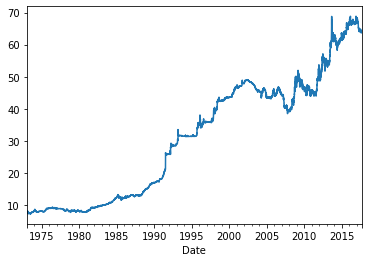

In [4]:
resampled_series.plot()

In [5]:
train_size=int(len(resampled_series)*90/100)
print(train_size)
test_size=len(resampled_series)-train_size
print(test_size)

14676
1631


In [6]:
train_data=resampled_series[:train_size]
test_data=resampled_series[train_size:]

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

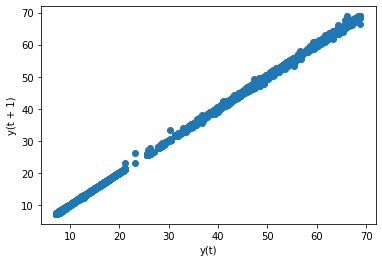

In [7]:
lag_plot(resampled_series)

### Dickey Fuller Test

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(resampled_series)

Results of Dickey-Fuller Test:
Test Statistic                     0.310295
p-value                            0.977812
#Lags Used                        36.000000
Number of Observations Used    16270.000000
Critical Value (1%)               -3.430752
Critical Value (5%)               -2.861718
Critical Value (10%)              -2.566865
dtype: float64


###  Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test

In [9]:
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(resampled_series)

Results of KPSS Test:
Test Statistic           35.489065
p-value                   0.010000
Lags Used                43.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Conclusion: Data is NOT Stationary. 

### ACF and PACF Plots

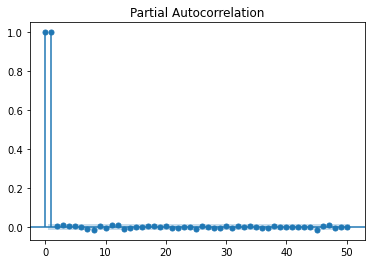

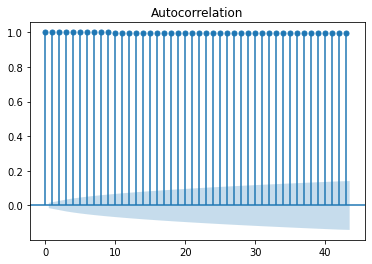

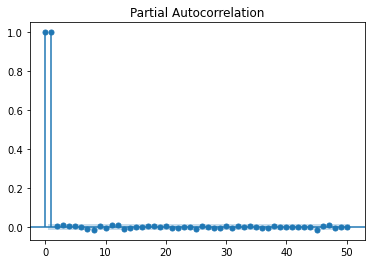

In [10]:
plot_acf(resampled_series)
plot_pacf(resampled_series, lags=50)

### TSA Decomposition

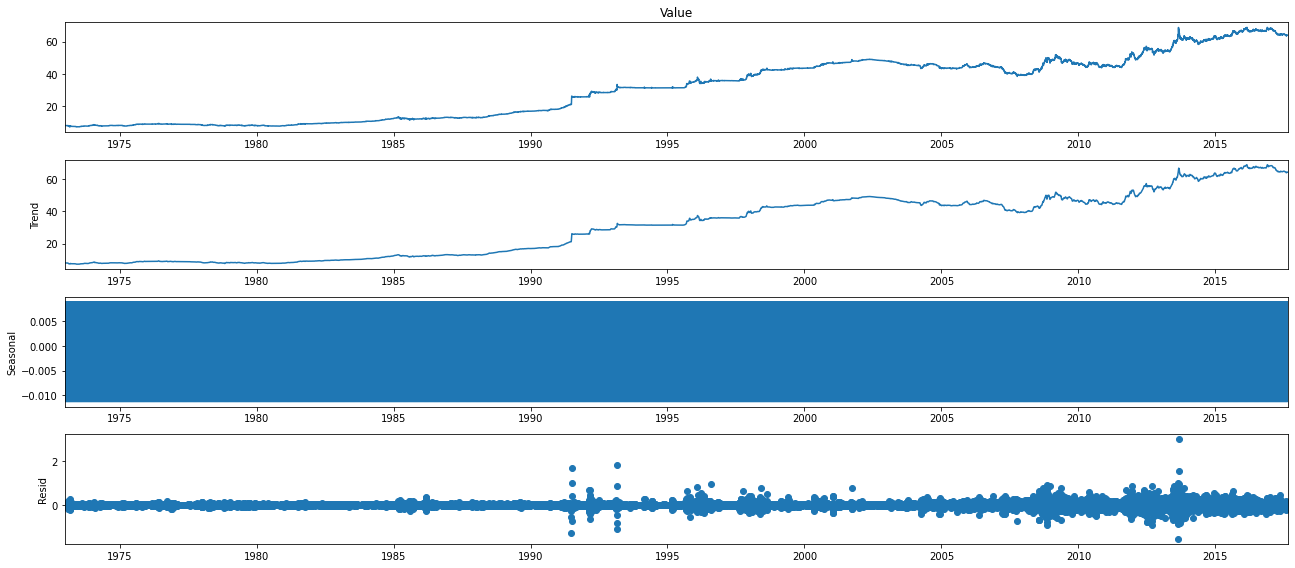

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(resampled_series, model='additive')
fig = decomposition.plot()
plt.show()

### Generating parameters for different ARIMA/SARIMAX Models

In [14]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


Every predictor added to a model increases R-squared and never decreases it. Thus, a model with more terms may seem to have a better fit just for the fact that it has more terms, while the adjusted R-squared compensates for the addition of variables and only increases if the new term enhances the model above what would be obtained by probability and decreases when a predictor enhances the model less than what is predicted by chance. In an overfitting condition, an incorrectly high value of R-squared is obtained, even when the model actually has a decreased ability to predict. This is not the case with the adjusted R-squared.

### Comparing Models for ARIMA

In [15]:
for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{} \nAIC = {} \nBIC = {} \nSSE = {}'.format(param,results.aic,results.bic,results.sse))
            
            #R square calculation
            data_mean = sum(train_data)/len(train_data)
            TSS_list = train_data-data_mean
            TSS_list = [i**2 for i in TSS_list]
            TSS = sum(TSS_list)
            R_squared = 1 - results.sse/TSS
            print("R squared = ",R_squared)
            
            #Adjusted R square calculation
            N = len(train_data)
            p = sum(param)
            R_squared_adj = 1 - ((1 - R_squared)*(N-1))/(N - (p + 1))
            print("Adjusted R squared = ",R_squared_adj)
            
            #Standard Error of Regression Calculation
            std_dev = pow(TSS/N,0.5)
            SER = pow(1 - R_squared_adj,0.5) * std_dev
            print("SER = ",SER)
            print("------------------------------")
            
        except:
            continue


ARIMA(0, 0, 0) 
AIC = 143348.19376483303 
BIC = 143355.78766547772 
SSE = 15007819.92636738
R squared =  -2.8176213915022252
Adjusted R squared =  -2.8176213915022252
SER =  31.978269151083097
------------------------------
ARIMA(0, 0, 1) 
AIC = 123073.24960513343 
BIC = 123088.43727013198 
SSE = 3769798.7216962255
R squared =  0.04105564217755542
Adjusted R squared =  0.040990292282651386
SER =  16.02765654710338
------------------------------
ARIMA(0, 0, 2) 
AIC = 103704.31017780739 
BIC = 103727.09147085501 
SSE = 1007334.4257326745
R squared =  0.7437588223378627
Adjusted R squared =  0.7437238954411596
SER =  8.285382882928396
------------------------------
ARIMA(0, 1, 0) 
AIC = -20048.221728622644 
BIC = -20040.62789612337 
SSE = 283.43131175999997
R squared =  0.9999279020241377
Adjusted R squared =  0.9999278971108233
SER =  0.138974416548267
------------------------------
ARIMA(0, 1, 1) 
AIC = -20069.735813664276 
BIC = -20054.548284965862 
SSE = 283.0455815135064
R squared = 

c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2) 
AIC = -20071.969720516627 
BIC = -20034.000898770588 
SSE = 300.05827608955343
R squared =  0.9999236725321121
Adjusted R squared =  0.9999236517216785
SER =  0.1430072810982218
------------------------------
ARIMA(2, 1, 0) 
AIC = -20067.731098333516 
BIC = -20044.949805285894 
SSE = 283.0738466140933
R squared =  0.9999279929545056
Adjusted R squared =  0.9999279782311458
SER =  0.1388962170316431
------------------------------
ARIMA(2, 1, 1) 
AIC = -20065.74607074528 
BIC = -20035.371013348453 
SSE = 283.51201130602453
R squared =  0.999927881496152
Adjusted R squared =  0.9999278618332786
SER =  0.13900841016981516
------------------------------
ARIMA(2, 1, 2) 
AIC = -20071.453679697133 
BIC = -20033.48519872465 
SSE = 319.8424685583613
R squared =  0.9999186399186644
Adjusted R squared =  0.9999186121885753
SER =  0.14765161814181232
------------------------------
ARIMA(2, 2, 0) 
AIC = -15704.316492416638 
BIC = -15681.53540383315 
SSE = 375.22532761877545
R squared

#### Best Model: ARIMA(1,0,1)

### Rolling Forecast with ARIMA

In [16]:
import statsmodels.api as sm
# walk-forward validation
history = [x for x in train_data]
predictions = list()

def StartARIMAForecasting(Actual, P, D, Q):
    model = sm.tsa.statespace.SARIMAX(Actual,
                                order=(P, D, Q),
                                enforce_stationarity=False,
                                enforce_invertibility=False)             

    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction

In [17]:
for i in range(len(test_data)):
    # predict
    yhat = StartARIMAForecasting(history,1,0,1)
    predictions.append(yhat)
    # observation
    obs = test_data[i]
    history.append(obs)
    print('>Predicted=%f, Expected=%f' % (yhat, obs))

>Predicted=54.331324, Expected=54.320000
>Predicted=54.325344, Expected=54.320000
>Predicted=54.325088, Expected=54.380000
>Predicted=54.382533, Expected=54.190000
>Predicted=54.203045, Expected=54.300000
>Predicted=54.300702, Expected=54.220000
>Predicted=54.228285, Expected=54.060000
>Predicted=54.071980, Expected=54.060000
>Predicted=54.065292, Expected=54.060000
>Predicted=54.065005, Expected=54.100000
>Predicted=54.103293, Expected=54.400000
>Predicted=54.392198, Expected=54.320000
>Predicted=54.327940, Expected=54.270000
>Predicted=54.277315, Expected=54.300000
>Predicted=54.303871, Expected=54.300000
>Predicted=54.305007, Expected=54.300000
>Predicted=54.305055, Expected=54.220000
>Predicted=54.228458, Expected=54.420000
>Predicted=54.416660, Expected=54.450000
>Predicted=54.453452, Expected=54.440000
>Predicted=54.445453, Expected=54.520000
>Predicted=54.521704, Expected=54.520000
>Predicted=54.524971, Expected=54.520000
>Predicted=54.525110, Expected=54.280000
>Predicted=54.29

>Predicted=62.723504, Expected=62.200000
>Predicted=62.220163, Expected=61.680000
>Predicted=61.699794, Expected=62.480000
>Predicted=62.467172, Expected=62.480000
>Predicted=62.486801, Expected=62.480000
>Predicted=62.487300, Expected=62.580000
>Predicted=62.584790, Expected=62.460000
>Predicted=62.470313, Expected=62.460000
>Predicted=62.467378, Expected=61.970000
>Predicted=61.989665, Expected=61.420000
>Predicted=61.440688, Expected=61.420000
>Predicted=61.427242, Expected=61.420000
>Predicted=61.426912, Expected=61.790000
>Predicted=61.787976, Expected=61.790000
>Predicted=61.796812, Expected=61.920000
>Predicted=61.923891, Expected=61.300000
>Predicted=61.322134, Expected=61.070000
>Predicted=61.082687, Expected=61.070000
>Predicted=61.076909, Expected=61.070000
>Predicted=61.076768, Expected=61.070000
>Predicted=61.076763, Expected=61.840000
>Predicted=61.828415, Expected=61.720000
>Predicted=61.729471, Expected=61.130000
>Predicted=61.151142, Expected=61.260000
>Predicted=61.26

>Predicted=60.186106, Expected=60.180000
>Predicted=60.186197, Expected=60.320000
>Predicted=60.322108, Expected=60.340000
>Predicted=60.345537, Expected=60.220000
>Predicted=60.229734, Expected=60.290000
>Predicted=60.294265, Expected=60.290000
>Predicted=60.296172, Expected=60.290000
>Predicted=60.296227, Expected=60.290000
>Predicted=60.296227, Expected=60.590000
>Predicted=60.587450, Expected=60.800000
>Predicted=60.799969, Expected=61.170000
>Predicted=61.165571, Expected=61.110000
>Predicted=61.117922, Expected=60.640000
>Predicted=60.660026, Expected=60.640000
>Predicted=60.646726, Expected=60.640000
>Predicted=60.646340, Expected=60.690000
>Predicted=60.694893, Expected=60.230000
>Predicted=60.249527, Expected=60.210000
>Predicted=60.217148, Expected=60.110000
>Predicted=60.119076, Expected=60.020000
>Predicted=60.028808, Expected=60.020000
>Predicted=60.026193, Expected=60.020000
>Predicted=60.026116, Expected=60.210000
>Predicted=60.210671, Expected=59.970000
>Predicted=59.98

>Predicted=61.205476, Expected=61.420000
>Predicted=61.420023, Expected=61.440000
>Predicted=61.445571, Expected=61.440000
>Predicted=61.446297, Expected=61.440000
>Predicted=61.446317, Expected=61.380000
>Predicted=61.388006, Expected=61.380000
>Predicted=61.386344, Expected=61.490000
>Predicted=61.493197, Expected=61.450000
>Predicted=61.457366, Expected=61.500000
>Predicted=61.504935, Expected=61.500000
>Predicted=61.506289, Expected=61.500000
>Predicted=61.506327, Expected=61.520000
>Predicted=61.525763, Expected=61.520000
>Predicted=61.526315, Expected=61.400000
>Predicted=61.409711, Expected=61.550000
>Predicted=61.552151, Expected=61.700000
>Predicted=61.701993, Expected=61.700000
>Predicted=61.706260, Expected=61.700000
>Predicted=61.706380, Expected=61.820000
>Predicted=61.823001, Expected=61.720000
>Predicted=61.729144, Expected=61.980000
>Predicted=61.979107, Expected=61.920000
>Predicted=61.927962, Expected=61.760000
>Predicted=61.771025, Expected=61.760000
>Predicted=61.76

>Predicted=63.366646, Expected=63.660000
>Predicted=63.658834, Expected=63.800000
>Predicted=63.802910, Expected=63.750000
>Predicted=63.757980, Expected=63.510000
>Predicted=63.523006, Expected=63.430000
>Predicted=63.438911, Expected=63.430000
>Predicted=63.436715, Expected=63.430000
>Predicted=63.436656, Expected=63.430000
>Predicted=63.436653, Expected=63.870000
>Predicted=63.865303, Expected=63.920000
>Predicted=63.925213, Expected=63.830000
>Predicted=63.839086, Expected=63.710000
>Predicted=63.719922, Expected=63.710000
>Predicted=63.716821, Expected=63.710000
>Predicted=63.716739, Expected=63.590000
>Predicted=63.599816, Expected=63.720000
>Predicted=63.723430, Expected=63.990000
>Predicted=63.989733, Expected=63.960000
>Predicted=63.967410, Expected=63.760000
>Predicted=63.771953, Expected=63.760000
>Predicted=63.766879, Expected=63.760000
>Predicted=63.766745, Expected=64.030000
>Predicted=64.029823, Expected=63.960000
>Predicted=63.968446, Expected=63.810000
>Predicted=63.82

>Predicted=66.819627, Expected=66.650000
>Predicted=66.661848, Expected=66.650000
>Predicted=66.657564, Expected=66.650000
>Predicted=66.657446, Expected=66.740000
>Predicted=66.745029, Expected=66.770000
>Predicted=66.776601, Expected=66.830000
>Predicted=66.835849, Expected=66.700000
>Predicted=66.710940, Expected=67.100000
>Predicted=67.096753, Expected=67.100000
>Predicted=67.107297, Expected=67.100000
>Predicted=67.107584, Expected=67.090000
>Predicted=67.097860, Expected=66.790000
>Predicted=66.805681, Expected=66.600000
>Predicted=66.612777, Expected=66.320000
>Predicted=66.334981, Expected=66.230000
>Predicted=66.239887, Expected=66.230000
>Predicted=66.237339, Expected=66.230000
>Predicted=66.237269, Expected=66.190000
>Predicted=66.198323, Expected=66.190000
>Predicted=66.197278, Expected=66.040000
>Predicted=66.051215, Expected=66.000000
>Predicted=66.008358, Expected=66.000000
>Predicted=66.007210, Expected=66.000000
>Predicted=66.007177, Expected=66.000000
>Predicted=66.00

>Predicted=67.536698, Expected=67.730000
>Predicted=67.732514, Expected=67.490000
>Predicted=67.503172, Expected=67.290000
>Predicted=67.302341, Expected=67.820000
>Predicted=67.814390, Expected=67.820000
>Predicted=67.827145, Expected=67.820000
>Predicted=67.827460, Expected=67.920000
>Predicted=67.925010, Expected=67.860000
>Predicted=67.868913, Expected=67.420000
>Predicted=67.438288, Expected=67.510000
>Predicted=67.515383, Expected=67.240000
>Predicted=67.253963, Expected=67.240000
>Predicted=67.247425, Expected=67.240000
>Predicted=67.247260, Expected=67.240000
>Predicted=67.247255, Expected=67.400000
>Predicted=67.403308, Expected=67.450000
>Predicted=67.455974, Expected=67.490000
>Predicted=67.496303, Expected=67.130000
>Predicted=67.146188, Expected=67.130000
>Predicted=67.137432, Expected=67.130000
>Predicted=67.137212, Expected=67.110000
>Predicted=67.117698, Expected=67.050000
>Predicted=67.058688, Expected=66.990000
>Predicted=66.998690, Expected=66.810000
>Predicted=66.82

>Predicted=68.117724, Expected=68.120000
>Predicted=68.127005, Expected=68.120000
>Predicted=68.127238, Expected=68.080000
>Predicted=68.088243, Expected=68.250000
>Predicted=68.252998, Expected=68.390000
>Predicted=68.393680, Expected=67.990000
>Predicted=68.007293, Expected=68.160000
>Predicted=68.163148, Expected=68.160000
>Predicted=68.167145, Expected=68.160000
>Predicted=68.167246, Expected=68.160000
>Predicted=68.167247, Expected=67.900000
>Predicted=67.913833, Expected=68.120000
>Predicted=68.121718, Expected=68.100000
>Predicted=68.107598, Expected=68.100000
>Predicted=68.107232, Expected=68.100000
>Predicted=68.107220, Expected=68.100000
>Predicted=68.107219, Expected=68.110000
>Predicted=68.116962, Expected=68.120000
>Predicted=68.126957, Expected=68.040000
>Predicted=68.049256, Expected=68.170000
>Predicted=68.173923, Expected=68.060000
>Predicted=68.069965, Expected=68.060000
>Predicted=68.067268, Expected=68.060000
>Predicted=68.067196, Expected=67.800000
>Predicted=67.81

>Predicted=64.386042, Expected=64.320000
>Predicted=64.327265, Expected=64.110000
>Predicted=64.120911, Expected=64.110000
>Predicted=64.115848, Expected=64.110000
>Predicted=64.115723, Expected=64.110000
>Predicted=64.115719, Expected=64.180000
>Predicted=64.184020, Expected=64.060000
>Predicted=64.068607, Expected=63.640000
>Predicted=63.655893, Expected=63.670000
>Predicted=63.675108, Expected=63.640000
>Predicted=63.646300, Expected=63.640000
>Predicted=63.645596, Expected=63.640000
>Predicted=63.645577, Expected=63.830000
>Predicted=63.830992, Expected=63.690000
>Predicted=63.698904, Expected=63.860000
>Predicted=63.861542, Expected=64.050000
>Predicted=64.050940, Expected=64.140000
>Predicted=64.143400, Expected=64.140000
>Predicted=64.145655, Expected=64.140000
>Predicted=64.145709, Expected=64.080000
>Predicted=64.087157, Expected=64.120000
>Predicted=64.124762, Expected=64.160000
>Predicted=64.164713, Expected=64.150000
>Predicted=64.155929, Expected=64.100000
>Predicted=64.10

### Visualisation of Predictions vs Observed

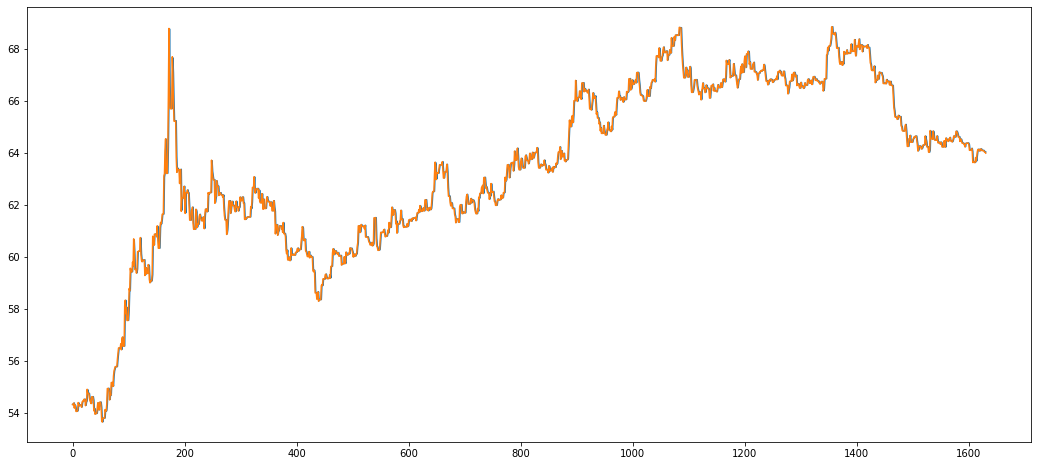

In [26]:
plt.plot(predictions) 
plt.plot(history[train_size:])

### MAE, MSE, RMSE and Forecast Error

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [48]:
mae = mean_absolute_error(history[train_size:], predictions)
print("MAE: ",mae)

MAE:  0.13842678919989518


In [50]:
mse = mean_squared_error(history[train_size:], predictions)
rmse = mse**(0.5)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)

MSE: 0.065
RMSE: 0.254


Forecast error = (Observed - Predicted) / Observed

In [45]:
forecast_error = [(history[train_size+i]-predictions[i])/history[train_size+i] for i in range(len(predictions))]

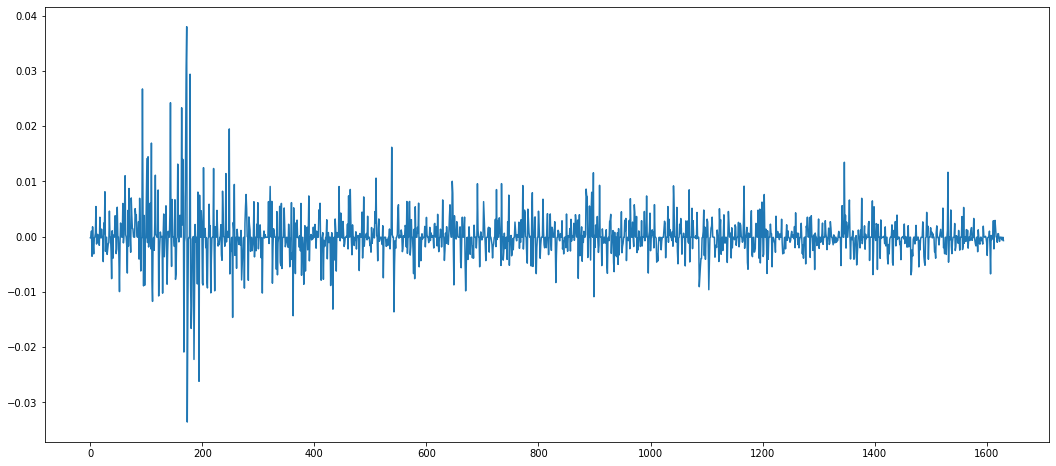

In [30]:
plt.plot(forecast_error)

### Residuals of the Test Data

In [59]:
mod = sm.tsa.statespace.SARIMAX(resampled_series,
                                            order=(1,0,1),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit()

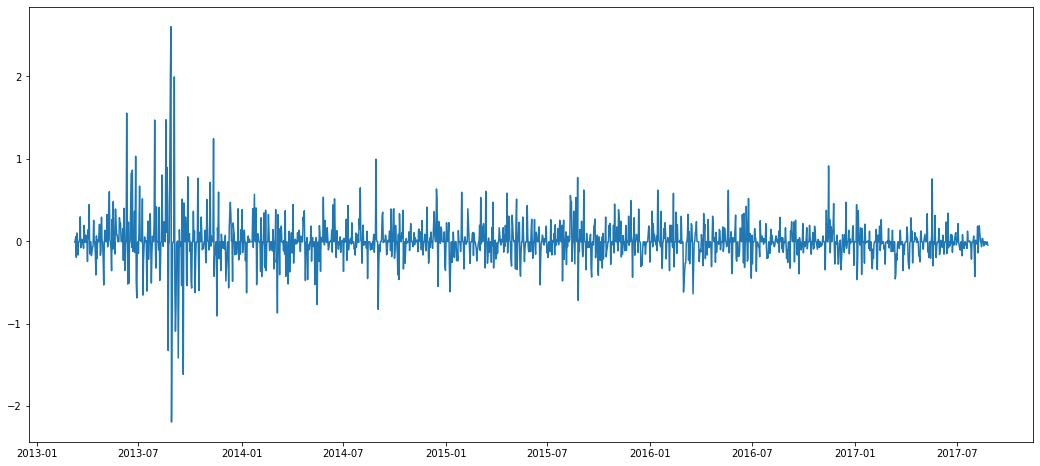

In [60]:
plt.plot(results.resid[train_size:])

### Comparing Models for SARIMAX

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 \nAIC = {} \nBIC = {} \nSSE = {}'.format(param,param_seasonal,results.aic,results.bic,results.sse))
            
            #R square calculation
            data_mean = sum(train_data)/len(train_data)
            TSS_list = train_data-data_mean
            TSS_list = [i**2 for i in TSS_list]
            TSS = sum(TSS_list)
            R_squared = 1 - results.sse/TSS
            print("R squared = ",R_squared)
            
            #Adjusted R square calculation
            N = len(train_data)
            p = sum(param) + sum(param_seasonal)
            R_squared_adj = 1 - ((1 - R_squared)*(N-1))/(N - (p + 1))
            print("Adjusted R squared = ",R_squared_adj)
            
            #Standard Error of Regression Calculation
            std_dev = pow(TSS/N,0.5)
            SER = pow(1 - R_squared_adj,0.5) * std_dev
            print("SER = ",SER)
            print("------------------------------")
        except:
            continue
